In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# System imports
from os import path
import math

# Third-Party Imports
import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata
from sklearn.cluster import DBSCAN as db

datadir = '/content/drive/My Drive/CS445Projects/FinalProj/'

In [3]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
################################################################################
# Helper functions



# This function blurs an image using a gaussian kernel which is useful for
# looking into an image's section to determine what color that part of the image
# is.
# It returns a blurred image based on the specfications

def blur_image(transformed_image, ksize, sigma):
  # Create the Gaussian kernel
  gaussian_kernel_1d = cv2.getGaussianKernel(ksize, sigma)
  gaussian_kernel_2d = gaussian_kernel_1d @ gaussian_kernel_1d.T

  # Apply the 2D filter
  blurred = cv2.filter2D(transformed_image, -1, gaussian_kernel_2d)

  return blurred



# This functon takes in a color as an array of 3 numbers from 0 to 1 and returns
# which color it is closest to: black, white, or green. In our testing, using
# sum of least squares was best to define what it means to be "close to". Green
# is also using 0.6 due to the nature of the images not being perfect, so it
# accomodates for values that should be green but may not be detected as such
# by making the threshold for detecting green smaller.
# It returns the color as black: -1, white: 1, green: 0.

def classify_color_rgb(avg_color):
  diff_w = np.square(avg_color - [1, 1, 1])
  diff_g = np.square(avg_color - [0, 0.6, 0])
  diff_b = np.square(avg_color - [0, 0, 0]) # for completion sake

  diff_w_s = np.sum(diff_w)
  diff_g_s = np.sum(diff_g)
  diff_b_s = np.sum(diff_b)

  # Find the smallest difference
  if (diff_b_s < diff_g_s and diff_b_s < diff_w_s):
    return -1 # black
  elif (diff_w_s < diff_b_s and diff_w_s < diff_g_s):
    return 1 # white
  else:
    return 0 # green



################################################################################
# This function takes in an image, the corners, and the intended location on the
# board in the form of i, j: the row and column of the piece you want to know
# is white, green or black. The row and columns are somewhat arbitrary since the
# images may be warped and rotated. Since we arent doing any heavy analysis, it
# doesnt matter for our purposes whether the board is rotated 90 degrees off of
# what one might expect.
# It returns the color, the transformed image, the blurred image, and the region
# for testing or debugging purposes.

def detect_piece(image, corners, i, j):

  # Corresponding square 400 x 400
  mapped_size = 400
  mapped_corners = np.array([
    [0, 0],
    [mapped_size-1, 0],
    [mapped_size-1, mapped_size-1],
    [0, mapped_size-1]
  ], dtype=np.float32)

  # Compute homography matrix
  H = cv2.getPerspectiveTransform(corners, mapped_corners)

  # Transform the image into a sqaure
  transformed = cv2.warpPerspective(image, H, (mapped_size, mapped_size))



  # Define paramters to blur the image.
  ksize = 5
  sigma = 3
  blurred_image = blur_image(transformed, ksize, sigma)



  # Define the sub-region where the piece you want to detect lies
  scale = int(mapped_size / 8)
  region = blurred_image[scale*i:scale*i+scale, scale*j:scale*j+scale]

  # Get the average color of the region
  avg_bgr = np.mean(region, axis=(0, 1))
  avg_rgb = avg_bgr[::-1]

  # Classify the average color as close to black, white or green
  color = classify_color_rgb(avg_rgb)

  return [color, transformed, blurred_image, region]

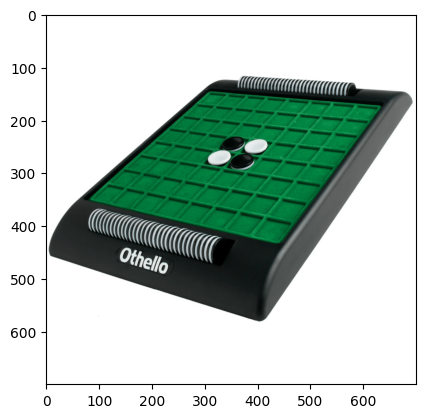

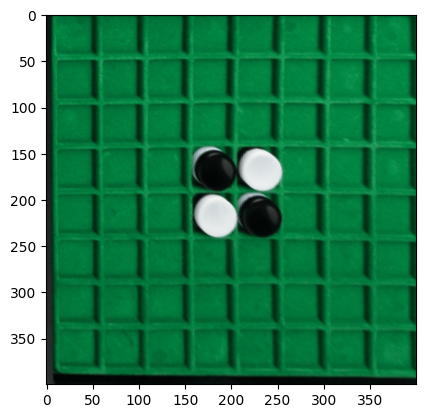

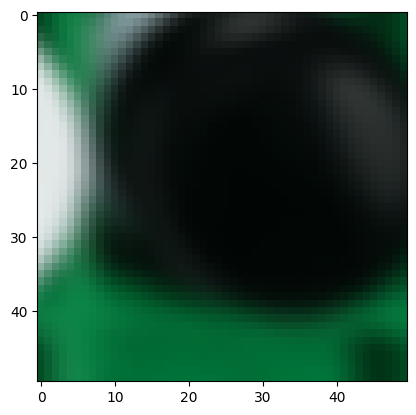

-1
[[ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. -1.  1.  0.  0.  0.]
 [ 0.  0.  0.  1. -1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]]


In [5]:
# testing the function

test_img_name = datadir+'othello3.png'
input_image = np.float32(cv2.imread(test_img_name, cv2.IMREAD_COLOR_RGB) / 255.0)

plt.imshow(input_image)
plt.show()

# corners (distorted quadrilateral)
corners = np.array([
  [432, 439],
  [629, 177],
  [300, 149],
  [64, 355]
], dtype=np.float32)

i = 4
j = 4

piece = detect_piece(input_image, corners, i, j)
plt.imshow(piece[1])
plt.show()
plt.imshow(piece[3])
plt.show()
print(piece[0])

board_state = np.zeros((8,8))
for i in range(8):
  for j in range(8):
    board_state[i][j]  = detect_piece(input_image, corners, i, j)[0]

print(board_state)
